# Refrigeration System Analysis

This  analyis estimates the fuel savings that could be achieved by upgrading the refrigeration system on board F/V Eigil B. The sections proceed as follows:

    -Refrigeration System Analysis
    -Defining parameters: 
        defines all variables that affect the refrigeration system
        -General cooling conditions:
            Defines variables that are indpendent of the refrigeration system, 
            such as the number of tank fills per season and the hold capacity.
        -Compressors
            Defines variables related each compressor model
            -New Bitzer system
                Defines the Bitzer compressor
            -New Frascold system
                Defines the Frascold compressor
            -Old Mycom system
                Defines the system installed
        -Circulation pumps
            Defines three versions of the circulation pumps
            - Basic circ pump
                Two pumps that are either on or off
            - VFD circ pump
                Two pumps that are controlled by a VFD
            - Circ pump with independent control
                Two pumps that can be turned on or off independently
        -Evaporator
            Defines one evaporator model
        - Auxiliary Generator BSFC
            Calculates the fuel consumption characteristics of the generator
        - Heat infiltration from ambient
            Describes the method used to account for heat infiltration
        - Fuel consumption calculation
            Calculates total fuel consumption of several system designs
        - Summary

The analysis relies on the python module 'refrigeration_analysis_functions' for computation. The module allows any number of compressors, evaporators, generators, circulation pumps and vessels to be defined. In this analysis, one vessel is defined, and several different compressors are simulated.

The analysis uses a simple model of new systems. The model includes a compressor (or two), two circulation pumps with vfd control, a condenser pump, a compressor cooling pump and a general term for system efficiency. A VFD on the compressor is not included, because it was found to have little value. The performance of the new compressors was looked up at a range of saturated suction temperatures and the data were used to estimate pump-down time.

The model of the old system uses the same components, but without any VFD control on the circulating pumps. Because I haven't been able to find performance data for the old compressor, its assumed to run at constant power rather than a power dependent on operating conditions.

The analysis is conducted in a Jupyter Notebook. A Jupyter Notebook allows text, figures and computer code to be presented in one document. Here, text is presented in black font fully left justified, while computer code (Python in this case) is presented a color-coded font and indented. Variables are defined and calculations are performed in the computer code "cells," while explanations are presented in the text "cells."

In [1]:
# This bit of code imports some software that the analysis uses 
# and defines some constants
import numpy as np
import matplotlib.pyplot as plt
import copy
import refrigeration_analysis_functions as raf
from imp import reload
reload(raf)
%matplotlib inline
water_heat_cap = 8.35 # btu/gal-F
joule_per_btu = 1055 
sec_per_hr = 3600
watt_per_kW = 1000
kW_per_hp = 0.746

# Defining parameters

In the following subsections, all of the parameters related to the cooling system are defined. These include parameters for the vessel and its operating procedures, the various compressors that are installed or proposed, circulation pumps, evaporator, and generator.

## General cooling conditions
This section defines variables that are consistent for all of the proposed systems. "system_eff" (defined as 0.95 below) is the ratio of true system efficiency to manufacturer specified system efficiency. It's a factor to allow for losses that are not included in the manufacturer's estimates. It's difficult to know what the factor should be for this system, so 0.95 was chosen as a reasonable place holder and it can be adjusted to explore the sensitivity of results to system efficiency.

In [2]:
# All values are stored to a "Vessel" object defined in the
# refrigeration_analysis_functions file
fv = raf.Vessel_RSW()
fv.sea_temp = 59
fv.target_temp = 33
fv.aft_tank_capacity = 19448 # gallons
fv.forward_tank_capacity = 14960 # gallons
fv.n_aft_tank_pulldown = 33 # pulldowns per year
fv.n_all_tank_pulldown = 1 # pulldowns per year
# Assumed overall system efficiency penalty
# for effects not modeled
fv.system_eff = 0.95
fv.lbs_fish_cooled = 1.588e6
fv.hrs_holding_aft_temp = 96
fv.maint_duty_cycle = 5
fv.hrs_holding_all_temp = 0 # Herring season only--no data available
# rate at which the holds warm when at temperature (deg F/hr)
fv.heat_infiltration_33 = 1.25 


## Compressors

This subsection defines several different compressors to be simulated

### New Bitzer system
The following data are from Bitzer Software v6.6.0 Open Drive Recips. Model W6FA-K with R717 (NH3). Condensing SDT 86 deg F. Liq subc 15 deg F, Suction gas superheat 15 deg F. Motor speed 1750/min, coupling 1:1. The parameter min_power is the power required to run the compressor at the minimum speed (900 r/min) at the minimum sst (24 deg F).

In [3]:
n_comp = 1
sst = [42, 40, 38, 36, 34, 32, 30, 28, 26, 24] # deg F
cap = np.array([747, 714, 682, 651, 621, 591, 563, 535, 508, 482]) * \
    1e3 * n_comp * fv.system_eff #btu/hr
power = np.array([28.3, 28.4, 28.5, 28.5, 28.5, 28.4, 28.2, 28.0, \
         27.8, 27.5]) * n_comp #kW
condenser_pump_cap = 3 * 0.746 # kW
condenser_eff = 0.8
aux_load = condenser_pump_cap/condenser_eff
# all of the compressor parameters are stored to a "Compressor"
# object defined in the refrigeration analysis functions file.
bitzer = raf.Compressor(sst, cap, power, aux_load)

The COP of the system is not used directly in this program, but it is a useful benchmark nonetheless. It's printed below for convenience (the equations are shown in the refrigeration_analysis_functions file, in the 'Compressor' initialization function). Note that the COP is derated by the system efficiency, since the capacity is defined using efficiency in the above cell.

In [4]:
bitzer.print_cop()
bitzer.print_capacity()

The COP is 7.35, 7.00, 6.66, 6.36, 6.07, 5.79, 5.56, 5.32, 5.09, 4.88
For Saturated Suction Temps (deg F) of 42.0, 40.0, 38.0, 36.0, 34.0, 32.0, 30.0,
 28.0, 26.0, 24.0
The capacity (kBtu/hr) is 710, 678, 648, 618, 590, 561, 535, 508, 483, 458


### New Frascold system

The following data are from Frascold Selection Software 3 v1.5. R507 model V20-59y, superheat = 10 F, useful fraction of superheat = 100%, condensing temp = 79 to 68 deg F, subcooling = 10 F.

In [5]:
n_fras = 2 # number of compressors in quote
# deg F
sst = np.array([45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 23])
#btu/hr
cap = np.array([343.0, 332.0, 322.0, 311.0, 301.0, 291.0, \
        282.0, 272.0, 263.0, 254.0, 245.0, 236.0]) * 1000
power = np.array([13.5, 13.3, 13.2, 13.0, 12.8, 12.7, \
                  12.5, 12.3, 12.2, 12.0, 11.8, 11.7]) #kW
condenser_pump_cap = 3 * 0.746 # kW
aux_load = condenser_pump_cap/condenser_eff
frascold = raf.Compressor(sst, cap, power, aux_load,\
        n_comp=n_fras, switch=True)
frascold_no_switch = raf.Compressor(sst, cap, power, aux_load,\
        n_comp=n_fras, switch=False)
frascold.print_cop()
frascold.print_capacity()
frascold.sst

The COP is 7.45, 7.32, 7.15, 7.01, 6.89, 6.71, 6.61, 6.48, 6.32, 6.20, 6.08, 5.9
1
For Saturated Suction Temps (deg F) of 45.0, 43.0, 41.0, 39.0, 37.0, 35.0, 33.0,
 31.0, 29.0, 27.0, 25.0, 23.0
The capacity (kBtu/hr) is 686, 664, 644, 622, 602, 582, 564, 544, 526, 508, 490,
 472


array([45, 43, 41, 39, 37, 35, 33, 31, 29, 27, 25, 23])

### Old Mycom system

Capacity and power data for the Mycom N4B compressor are not available, so the power is estimated based on a similar model with a higher power rating

In [6]:
motor_power = 40 * 0.746 # kW
aft_pump_down_time = 13.5 # hrs
total_time = 504.2 #hrs
motor_load_factor = 0.65 # assumed

Based on conversations with John Farr at Mayekawa MFG Co. the best analogue to the N4B installed on board is the N4WB. The system on board is belt driven and the pulley ratio is unknown. However, the N4WB most closely matches the power rating of the compressor motor when it is run at the minimum speed of 800 RPM. The data shown below are from the Mayekawa MySelect software for the 4WB compressor with a belt drive and unloaders.

The sst range was chosen based on reported pressures from Dan Dunn. Dan reported that the suction pressure typically ranged from 30 to 60 psig, which corresponds to a saturation temperature of 18 to 43 F. The discharge pressure ranged from 175 to 90 psig.The maximum suction pressure allowed for the 4WB is 56.3 PSI, so that value was used for the analysis, and the discharge pressure was reduced by a similar amount.

Unlike the new models that were simulated with a constant condensing temperature, this old model assumes a range of condensing temperatures from 91.4 to 58.5, as suggested by the discharge pressures mentioned by Dan

An age factor is included in the model to allow for some capacity loss due to wear on the system. The age factor is set to 0.9 in this analysis.

In [7]:
age_factor = 0.9
sst = np.array([38.4, 36.7, 34.5, 32.3, 29.9, 27.5, 25, 22.3, \
                19.5, 16.6])
condenser_pump_cap = 3 * 0.746 # kW
compressor_cool_pump = 2 * 0.746 # kW
cool_pump_eff = 0.8
aux_load = condenser_pump_cap / condenser_eff \
    + compressor_cool_pump / cool_pump_eff
# Power and capacity are for the N4WB, a newer model with a 
# higher capacity. The values for the N4WB derated so that
# the maximum power is 40 hp.
cap = np.array([899.1, 878.2, 847.9, 817.5, 786.8, 757.1, 725.7, 649,\
                661.8, 628.1]) * 1e3 # Btu/hr
motor_eff = 0.93
power = np.array([54.9, 52.3, 49.8, 47.4, 45, 42.8, 40.6, 38.6,\
                  36.6, 34.9]) * kW_per_hp # kW
derating = motor_power * motor_eff/max(power)
cap *= derating * age_factor
power *= (derating / motor_eff)
mycom = raf.Compressor(sst, cap, power, aux_load)
mycom.print_cop()
mycom.print_capacity()

The COP is 5.38, 5.52, 5.60, 5.67, 5.75, 5.82, 5.88, 5.53, 5.95, 5.92
For Saturated Suction Temps (deg F) of 38.4, 36.7, 34.5, 32.3, 29.9, 27.5, 25.0,
 22.3, 19.5, 16.6
The capacity (kBtu/hr) is 548, 536, 517, 499, 480, 462, 443, 396, 404, 383


The old system had unloaders installed. The model allows the compressor to run in the 'unloaded' condition when it is maintaining hold temperature. The performance of the compressor in the unloaded condition was estimated based on manufacturer's specifications for the N4WB as in the previous cell. The specification indicated that the compressor capacity decreased by a factor of 0.49 when unloaded, and the compressor power absorption decreased by a factor of 0.56. This corresponds to an efficiency loss of 14%

In [8]:
age_factor = 0.9
sst = np.array([38.4, 36.7, 34.5, 32.3, 29.9, 27.5, 25, 22.3, \
                19.5, 16.6])
condenser_pump_cap = 3 * 0.746 # kW
compressor_cool_pump = 2 * 0.746 # kW
cool_pump_eff = 0.8
aux_load = condenser_pump_cap / condenser_eff \
    + compressor_cool_pump / cool_pump_eff
# Power and capacity are for the N4WB, a newer model with a 
# higher capacity. The values for the N4WB derated so that
# the maximum power is 40 hp.
cap = np.array([899.1, 878.2, 847.9, 817.5, 786.8, 757.1, 725.7, 649,\
                661.8, 628.1]) * 1e3 # Btu/hr
motor_eff = 0.93
power = np.array([54.9, 52.3, 49.8, 47.4, 45, 42.8, 40.6, 38.6,\
                  36.6, 34.9]) * kW_per_hp # kW
derating = motor_power * motor_eff/max(power)
cap *= derating * age_factor
power *= (derating / motor_eff)
ul = {'power':[1,20.1/34.9], 'capacity':[1,307.8/628.1]}
mycom2 = raf.Compressor(sst, cap, power, aux_load, unloaders=ul)
mycom2.print_cop()
mycom2.print_capacity()

The COP is 5.38, 5.52, 5.60, 5.67, 5.75, 5.82, 5.88, 5.53, 5.95, 5.92
For Saturated Suction Temps (deg F) of 38.4, 36.7, 34.5, 32.3, 29.9, 27.5, 25.0,
 22.3, 19.5, 16.6
The capacity (kBtu/hr) is 548, 536, 517, 499, 480, 462, 443, 396, 404, 383


## Circulation pumps
The circulation pumps account for over 1/3 of the power consumed. They are particularly impactful because not only do they require power to run, all of the power that they use ultimately ends up as heat in the fish hold that must be removed by the compressor--the more power the circulation pumps use, the more work must be done by the compressor. Motor efficiency is based on the Pre-EPAct Motor Efficiency Table.

Three different types of circulation pump systems are modeled, as defined below.

In [9]:
rated_kw = 7.5 * 0.746 # kW
max_flow = fv.aft_tank_capacity / (64/60) # gallons/hr
eff = 0.85

### Basic circ pump
The basic circulation pump system has two pumps that run at full power whenever they are turned on.

In [10]:
circ1 = raf.CircPump(max_flow, rated_kw, n_pump=2,\
                     motor_eff=0.85)

### VFD circ pump
With a VFD installed on the circ pumps, they always run just fast enough to maintain the required flow through the evaporator. The "fr" parameter is the "filling speed ratio": the fractional speed at which the pumps run when filling the holds. Setting the speed to 52/60 adds a bit of time to filling, but saves even more fuel.

In [11]:
# Assumed VFD efficiency based on Z1000 Specification
# Section 15172
vfd_eff = 0.98
# The second has a VFD on both pumps and the pumps
# run at 52/60 speed when filling the hold
circ2 = raf.CircPump(max_flow, rated_kw/vfd_eff, \
        n_pump=2, vfd=True, fr=52/60, motor_eff=eff)

### Circ pump with indpendent control
The third circ pump system does not have a vfd, but does allow one circ pump to be switched off if one is sufficient to supply the evaporator with the required flow. This capability is added by setting the variable "switch" to "True".

In [12]:
# The third has no VFD, but it is possible to run 
# just one circ pump
circ3 = raf.CircPump(max_flow, rated_kw, n_pump=2, \
                     switch=True, motor_eff=eff)

## Evaporator
The only specification of the evaporator that affects the fuel efficiency of the system in this model is the maximum allowable change in temperature of the refrigerated sea water in the heat exchanger.

In [13]:
max_temp_change = 5 #deg F
evap5 = raf.Evaporator(max_temp_change)

## Auxiliary Generator BSFC
The fuel consumption as a function of load is calculated based on manufacturer's data: Engine Performance Curve John Deere  4045TFM75. John Deere. 2007.  <http://silniki.info.pl/upload/pdf/karta%20produktu%204045TFM75%20
55%20kW%20@1500%20&%201800.pdf>

The figure shows that a linear equation fits the data well. The fit shown in the figure below is used in the remainder of the report to estimate fuel consumption.

The BSFC shown below is for the engine only. It does 
not include the inefficiency of the motor side of the generator.
The estimated BSFC at a load of 32 kW is  240.8  gram/kWh
The estimated thermal efficiency of the generator at a load 
 of 32.0 kW is 29.9%


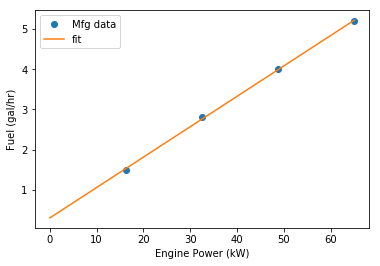

In [14]:
reload(raf)
gen_rating = 65 # kW
eng_rating = 73 # kW
eng_power = eng_rating * np.array([0.25, 0.5, 0.75, 1.0])
fuel = np.array([1.5, 2.8, 4.0, 5.2]) #gal/hr
# Note: According to the doc, the engine is rated to 73 kW, 
# although the generator on board is rated to 65 kW. The 73 kW 
# engine rating is used here. An efficiency of 65/73 = 89%
# is used for converting the engine's mechanical power to 
# electrical power
gen_eff = gen_rating/eng_rating
Aux1 = raf.Generator(eng_power, fuel, gen_eff)
Aux1.plot_fit()

# ---- Sanity check-----
# testpoint is a load near 1/2 of the generator capacity
testpoint = 32 #kW 
fuel_density = 3179 # assumed fuel density (gram/gallon)
# gram/kWh
p = Aux1.bsfc_coeffs
bsfc = (p[1]+p[0]*testpoint) / (testpoint / Aux1.motor_eff)\
    * fuel_density 
#eng_load = '{:2.1f}'.format(powertest[testpoint])
print("The BSFC shown below is for the engine only. It does" +\
     " \nnot include the inefficiency of the motor side of the " +\
     "generator.")
print("The estimated BSFC at a load of " + str(testpoint) + \
      ' kW is ', '{:3.1f}'.format(bsfc), ' gram/kWh')
gen_eff = testpoint / (134000 * (p[1]+p[0]*testpoint) / 3412)
gen_eff = '{:2.1f}'.format(gen_eff*100)
gen_load = '{:2.1f}'.format(testpoint)
print("The estimated thermal efficiency of the generator at " +\
    "a load \n of " + gen_load + " kW is " + gen_eff + "%")

The second auxiliary generator has the same engine (John Deere 4045TFM75), but the generator is rated to 100 kW rather than 65 kW. Data sheets for the 4045TFM75 reveals that the engine is rated to 80 kW under M1 conditions (operating over 3000 hours per year and load factors over 65%) and to 101 kW under M3 conditions (up to 2000 hours per year, and load factors under 50%). For simplicity, only the small generator is used in this calculation

## Heat infiltration from ambient
The rate at which the compressor cools the hold is affected by the infiltration of heat from ambient. Based on interviews with the skipper, the hold temperature rises by about 1.25 deg F/hr once it is at temp. The rate of temperature change ($dT_{hold}$) with respect to time ($dt$) is defined by the equation below: 
$$\frac{d T_{hold}}{d t} = (T_{ambient}-T_{hold}) * UA $$ 

where $U$ is the average thermal conductivity of the hold and $A$ is the surface area of the hold. Since $UA$ and $T_{ambient}$ are constant for a given hold, the rate of heat loss is linearly related to the temperature of the hold. It's assumed that the rate of temperature change of both the aft and forward holds is the same. The heat infiltration rate associated with each SST associated with the compressors is calculated by assuming that the rate of temperature change increases linearly from 0 when the water is at sea temperature to heat_infiltration_33 when the water is at 33 deg F.

# Fuel consumption calculation
Fuel consumption based on the previously defined variables is done below.

In [23]:
reload(raf)
name = "Old system without unloader"
# the 'override' parameter allows a duty cycle to be entered directly
# for the maintaining hold temperature mode. If it is not defined,
# the duty cycle is calculated based on the heat infiltration rate.
# With 'override' defined, the duty cycle is set to the value given.
old_system = raf.Season(fv, mycom, circ1, evap5, Aux1, name=name,\
                        override=0.5)
name = "Old system as built"
old_system2 = raf.Season(fv, mycom2, circ1, evap5, Aux1, name=name,\
                        override=0.5)
name = "Bitzer basic"
bitzer1 = raf.Season(fv, bitzer, circ1, evap5, Aux1, name=name)
name = "Bitzer with vfd"
bitzer2 = raf.Season(fv, bitzer, circ2, evap5, Aux1, name=name)
name = "Bitzer with duty cycle override"
bitzer3 = raf.Season(fv, bitzer, circ1, evap5, Aux1, name=name, \
                     override=0.5)
name = "Frascold basic"
frascold1 = raf.Season(fv, frascold, circ1, evap5, Aux1, name=name)
name = "Frascold with independent circ pumps"
frascold2 = raf.Season(fv, frascold, circ3, evap5, Aux1, name=name)
name = "Frascold with vfd"
frascold3 = raf.Season(fv, frascold, circ2, evap5, Aux1, name=name)
name = "Frascold both compressors on with duty cycle override"
frascold4 = raf.Season(fv, frascold_no_switch, circ1, evap5,\
                       Aux1, name=name, override=0.5)
results = [old_system, old_system2, bitzer1, bitzer2, bitzer3, \
           frascold1, frascold2, frascold3, frascold4]
raf.results_table(results)

Total fuel consumed in a year (gallons):
Old system without unloader 2037
Old system as built 2008
Bitzer basic 1583
Bitzer with vfd 1044
Bitzer with duty cycle override 1736
Frascold basic 1538
Frascold with independent circ pumps 1254
Frascold with vfd 1016
Frascold both compressors on with duty cycle override 1678


Various aspects of each season are stored in the variables old_system, frascold1, etc. For example, if you want to see a break down of how fuel was used for the frascold system with inependent circ pumps, the command is 'frascold2.fuel', as shown below. To see all of the command available for 'frascold 2', you may type dir(frascold2) and press shift enter. Various data for each system are printed below for viewing convenience.

In [24]:
frascold2.fuel

{'filling tanks': 96.16460630699612,
 'herring maintenance': 0.0,
 'herring pulldowns': 87.044460814987659,
 'salmon maintenance': 20.394978317517186,
 'salmon pulldowns': 1050.1859961738287}

For comparison, the same break down is shown for the old system and the frascold system without independent control below.

In [25]:
print(old_system.name)
old_system.fuel

Old system without unloader


{'filling tanks': 96.16460630699612,
 'herring maintenance': 0.0,
 'herring pulldowns': 48.007284680619691,
 'salmon maintenance': 148.09029200801123,
 'salmon pulldowns': 1744.5673268715452}

In [26]:
print(frascold1.name)
frascold1.fuel

Frascold basic


{'filling tanks': 96.16460630699612,
 'herring maintenance': 0.0,
 'herring pulldowns': 116.84541028349184,
 'salmon maintenance': 28.241341855636893,
 'salmon pulldowns': 1296.9252753790038}

In [27]:
string = 'The range of capacity for the frascold system is '
string += '{:0.0f}'.format(min(frascold.capacity/1000*frascold.n))
string += ' to '
string += '{:0.0f}'.format(max(frascold.capacity/1000*frascold.n))
string += ' kbtu/hr.'
print(string)

The range of capacity for the frascold system is 472 to 686 kbtu/hr.


In [28]:
string = 'The range of capacity for the Mycom system is '
string += '{:0.0f}'.format(min(mycom.capacity/1000))
string += ' to '
string += '{:0.0f}'.format(max(mycom.capacity/1000))
string += ' kbtu/hr.'
print(string)

The range of capacity for the Mycom system is 383 to 548 kbtu/hr.


In [29]:
frascold.print_cop()

The COP is 7.45, 7.32, 7.15, 7.01, 6.89, 6.71, 6.61, 6.48, 6.32, 6.20, 6.08, 5.9
1
For Saturated Suction Temps (deg F) of 45.0, 43.0, 41.0, 39.0, 37.0, 35.0, 33.0,
 31.0, 29.0, 27.0, 25.0, 23.0


In [30]:
mycom.print_cop()

The COP is 5.38, 5.52, 5.60, 5.67, 5.75, 5.82, 5.88, 5.53, 5.95, 5.92
For Saturated Suction Temps (deg F) of 38.4, 36.7, 34.5, 32.3, 29.9, 27.5, 25.0,
 22.3, 19.5, 16.6


The COP of the Mycom system increases as the hold temperature decreases becauses the discharge pressure decreases more quickly than the suction pressure in this model. This is because Dan Dunn reported that the discharge pressure ranges from 175 psi to 90 psig, and the suction pressure ranges from 60 to 30 psi. The model assumes a linear decrease in discharge pressure from 175 to 90 psig as the suction pressure goes from 60 to 30 psig. The COP is higher when the compressor lif is from 30 to 90 psig than from 60 to 175 psig.

# Summary

The old system was estimated at 2008 gal/yr, while the new system was estimated at 1583 gal/yr with the Bitzer system and 1538 gal/yr with the Frascold system. The new systems can be improved by allowing for independent control of the circ pumps or adding a vfd to the circ pumps. Adding independent control of the circ pumps to the Frascold system would reduce fuel consumption to 1254 gal/yr and adding VFD control of the circ pumps would reduce fuel consumption to 1016 gal/yr.


The accuracy of the above estimates are primarily limited by the following four factors:

1.) Specific data for the old compressor is not available. The old compressor performance is based on a specifications for a similar compressor produced by Mycom, but the discrepancy between the performance of the compressor model on board and the compressor model used in the calculation.

2.) Operating conditions of the old system were not rigorously recorded.

3.) Degradataion of the efficiency of the old system over time is unknown.

4.) Inefficiency in the system outside of manufacturer specifications for the compressor and other components has not been measured, so the true overall system efficiency is unknown.